In [15]:
'''Colorization autoencoder
The autoencoder is trained with grayscale images as input
and colored images as output.
Colorization autoencoder can be treated like the opposite
of denoising autoencoder. Instead of removing noise, colorization
adds noise (color) to the grayscale image.
Grayscale Images --> Colorization --> Color Images
'''
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os


# convert from color image (RGB) to grayscale
# source: opencv.org
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()

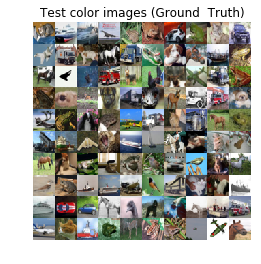

In [16]:
# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs)
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

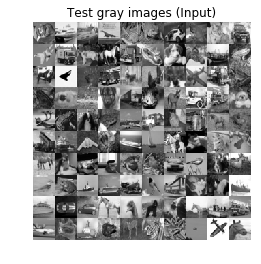

In [17]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [18]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [19]:
# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

## Encoder 

In [21]:
# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


## Decoder

In [23]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731      
Total para

## Autoencoder = encoder + decoder


In [22]:
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [28]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=1.5*0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# called every epoch 

callbacks = [lr_reducer, checkpoint]

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 382s 8ms/step - loss: 0.0139 - val_loss: 0.0112

Epoch 00001: val_loss improved from inf to 0.01123, saving model to C:\Users\Insaf.Ashrapov\Desktop\ml\saved_models\colorized_ae_model.001.h5
Epoch 2/15
50000/50000 [==============================] - 384s 8ms/step - loss: 0.0102 - val_loss: 0.0095

Epoch 00002: val_loss improved from 0.01123 to 0.00951, saving model to C:\Users\Insaf.Ashrapov\Desktop\ml\saved_models\colorized_ae_model.002.h5
Epoch 3/15
50000/50000 [==============================] - 383s 8ms/step - loss: 0.0092 - val_loss: 0.0089

Epoch 00003: val_loss improved from 0.00951 to 0.00887, saving model to C:\Users\Insaf.Ashrapov\Desktop\ml\saved_models\colorized_ae_model.003.h5
Epoch 4/15
50000/50000 [==============================] - 379s 8ms/step - loss: 0.0086 - val_loss: 0.0084

Epoch 00004: val_loss improved from 0.00887 to 0.00841, saving model to C:\Users\Insaf.A

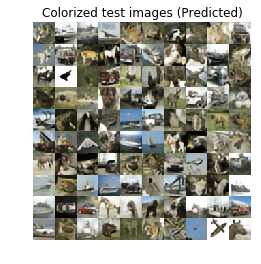

In [29]:
# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=15,
                batch_size=batch_size,
                callbacks=callbacks)

# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

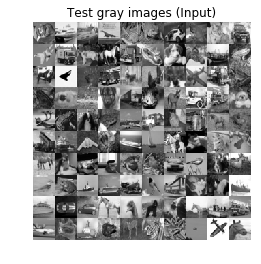

In [43]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()